In [124]:
import gzip
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.stats import diagnostic
from scipy import stats

## 1. Data loading

In [125]:
with gzip.open('../data/wiki-RfA.txt.gz', 'rt', encoding='utf-8') as f:
    blocks = f.read().strip().split('\n\n')  # Assuming each record is separated by a blank line

data = []

# Parse each block of text into a dictionary
for block in blocks:
    record = {}
    for line in block.split('\n'):
        if line:
            key, value = line.split(':', 1)  # Split on the first colon only
            record[key.strip()] = value.strip()
    data.append(record)

# Create a DataFrame from the list of dictionaries
df = pd.DataFrame(data)

#Rename the columns
df.columns = ['source', 'target', 'vote', 'result', 'year_election', 'date_vote', 'comment']

In [126]:
df

,source,target,vote,result,year_election,date_vote,comment
0,Steel1943,BDD,1,1,2013,"23:13, 19 April 2013",'''Support''' as co-nom.
1,Cuchullain,BDD,1,1,2013,"01:04, 20 April 2013",'''Support''' as nominator.--
2,INeverCry,BDD,1,1,2013,"23:43, 19 April 2013",'''Support''' per noms.
3,Cncmaster,BDD,1,1,2013,"00:11, 20 April 2013",'''Support''' per noms. BDD is a strong contri...
4,Miniapolis,BDD,1,1,2013,"00:56, 20 April 2013","'''Support''', with great pleasure. I work wit..."
...,...,...,...,...,...,...,...
198270,172,Vancouverguy,1,1,2003,"02:51, 2 Sep 2003",Support
198271,Angela,WhisperToMe,1,1,2003,"23:45, 26 Nov 2003",Support.
198272,Jiang,WhisperToMe,1,1,2003,,Support. --
198273,Pakaran,WhisperToMe,1,1,2003,"05:38, 5 Dec 2003",Support. Age has nothing to do with maturity....


## 2. Preliminary checks

### 2.1 Check the date and time of votes : 

In [128]:
# Define a function to extract date components
def extract_date_components(date_str):
    try:
        # Split the date string by the comma and space to separate time and date parts
        time_part, date_part = date_str.split(', ')
        # Split the time part by the colon to separate hours and minutes
        hour, minute = time_part.split(':')
        # Split the date part by space to separate day, month, and year
        day, month, year = date_part.split(' ')
        
        return pd.Series({
            "hour": hour,
            "minute": minute,
            "day": day,
            "month": month,
            "year_vote": year
        })
    except ValueError:
        # If there is a ValueError, return None for each component
        return pd.Series({
            "hour": None,
            "minute": None,
            "day": None,
            "month": None,
            "year_vote": None
        })

# Apply the function to each row in the 'date' column
date_components = df['date_vote'].apply(extract_date_components)

# Concatenate the new DataFrame with the original one (if needed)
new_df = pd.concat([df, date_components], axis=1)

new_df

,source,target,vote,result,year_election,date_vote,comment,hour,minute,day,month,year_vote
0,Steel1943,BDD,1,1,2013,"23:13, 19 April 2013",'''Support''' as co-nom.,23,13,19,April,2013
1,Cuchullain,BDD,1,1,2013,"01:04, 20 April 2013",'''Support''' as nominator.--,01,04,20,April,2013
2,INeverCry,BDD,1,1,2013,"23:43, 19 April 2013",'''Support''' per noms.,23,43,19,April,2013
3,Cncmaster,BDD,1,1,2013,"00:11, 20 April 2013",'''Support''' per noms. BDD is a strong contri...,00,11,20,April,2013
4,Miniapolis,BDD,1,1,2013,"00:56, 20 April 2013","'''Support''', with great pleasure. I work wit...",00,56,20,April,2013
...,...,...,...,...,...,...,...,...,...,...,...,...
198270,172,Vancouverguy,1,1,2003,"02:51, 2 Sep 2003",Support,02,51,2,Sep,2003
198271,Angela,WhisperToMe,1,1,2003,"23:45, 26 Nov 2003",Support.,23,45,26,Nov,2003
198272,Jiang,WhisperToMe,1,1,2003,,Support. --,None,None,None,None,None
198273,Pakaran,WhisperToMe,1,1,2003,"05:38, 5 Dec 2003",Support. Age has nothing to do with maturity....,05,38,5,Dec,2003


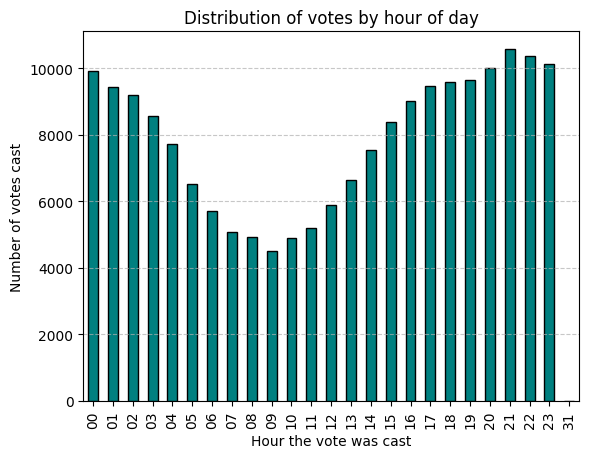

In [135]:
#Look at the distribution for the values of the hour with histogram
new_df['hour'].value_counts().sort_index().plot(kind='bar' , color = 'teal' ,  edgecolor='black')
plt.xlabel('Hour the vote was cast')
plt.ylabel('Number of votes cast')
# Set a grid for easier reference to the quantities
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.title('Distribution of votes by hour of day')
plt.show()

In [ ]:
#Remove from the dataframe the rows with the value of the hour as 31
new_df = new_df[new_df['hour'] != '31']

In this dataset, there is a record of a vote occurring at the 31st hour, which is not a valid time. Given that the number of occurrences is negligible, we have chosen to exclude this data point from the dataframe. This removal is unlikely to affect the overall analysis of the dataset due to its minimal incidence.

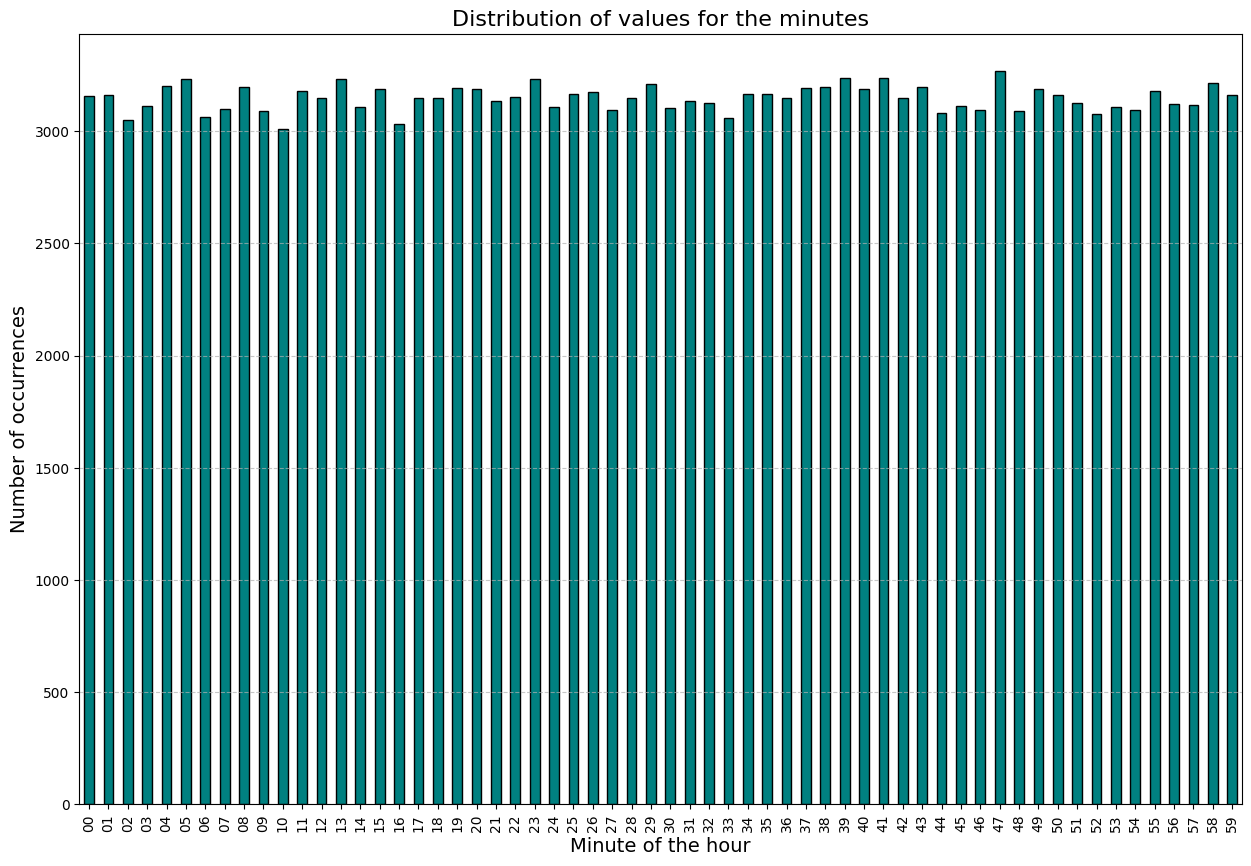

In [139]:
# Set the figure size for better visibility
plt.figure(figsize=(15, 10))

ax = new_df['minute'].value_counts().sort_index().plot(kind='bar', color='teal', edgecolor='black')

ax.set_xlabel('Minute of the hour', fontsize=14)
ax.set_ylabel('Number of occurrences', fontsize=14)
ax.set_title('Distribution of values for the minutes', fontsize=16)

plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

The minute values appear to be in order, and their distribution is evenly spread, which aligns with expectations.

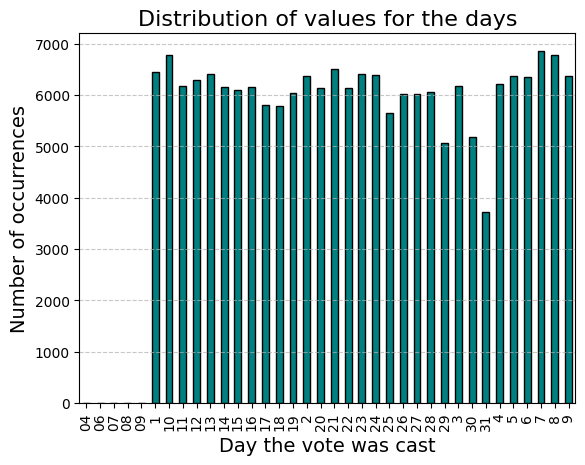

In [143]:
#Look at the distribution of the values for the days with histogram and order the values

ax = new_df['day'].value_counts().sort_index().plot(kind='bar' ,  color='teal', edgecolor='black')
plt.grid(axis='y', linestyle='--', alpha=0.7)

ax.set_xlabel('Day the vote was cast', fontsize=14)
ax.set_ylabel('Number of occurrences', fontsize=14)
ax.set_title('Distribution of values for the days', fontsize=16)

plt.show()

The values for the day also seem to be correct.

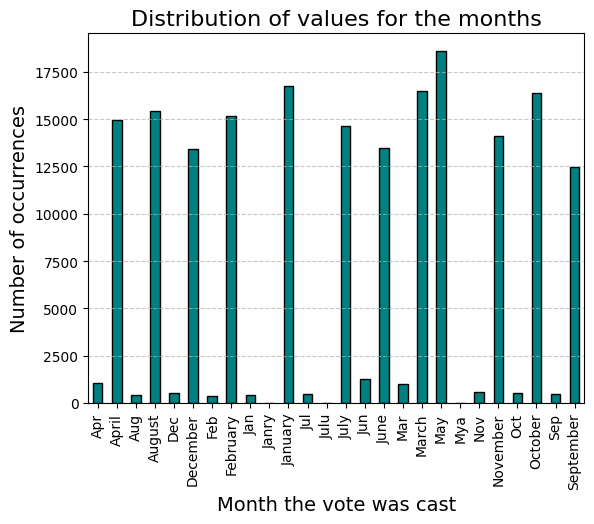

In [144]:
#Look at the distribution of the values for the months with histogram and order the values
ax = new_df['month'].value_counts().sort_index().plot(kind='bar' , color='teal', edgecolor='black')
plt.grid(axis='y', linestyle='--', alpha=0.7)

ax.set_xlabel('Month the vote was cast', fontsize=14)
ax.set_ylabel('Number of occurrences', fontsize=14)
ax.set_title('Distribution of values for the months', fontsize=16)

plt.show()

We can see that for specific months different values appear in the dataset. For example, for July we have Jul, Julu, July ; for the October we have Oct, October. 

In [145]:
#Map the values of the months to the full name of the month
month_map = { 
    "Apr" : "April",
    "April" : "April",
    "Aug" : "August",
    "August" : "August",
    "Dec" : "December",
    "December" : "December",
    "Feb" : "February",
    "February" : "February",
    "Jan" : "January",
    "Janry" : "January",
    "January" : "January",
    "Jul" : "July",
    "Julu" : "July",
    "July" : "July",
    "Jun" : "June",
    "June" : "June",
    "Mar" : "March",
    "March" : "March",
    "May" : "May",
    "Mya" : "May",
    "Nov" : "November",
    "November" : "November",
    "Oct" : "October",
    "October" : "October",
    "Sep" : "September",
    "September" : "September"
}

def correction_month (month) : 
    return month_map.get(month, month)

new_df['month'] = new_df['month'].apply(correction_month)
new_df

,source,target,vote,result,year_election,date_vote,comment,hour,minute,day,month,year_vote
0,Steel1943,BDD,1,1,2013,"23:13, 19 April 2013",'''Support''' as co-nom.,23,13,19,April,2013
1,Cuchullain,BDD,1,1,2013,"01:04, 20 April 2013",'''Support''' as nominator.--,01,04,20,April,2013
2,INeverCry,BDD,1,1,2013,"23:43, 19 April 2013",'''Support''' per noms.,23,43,19,April,2013
3,Cncmaster,BDD,1,1,2013,"00:11, 20 April 2013",'''Support''' per noms. BDD is a strong contri...,00,11,20,April,2013
4,Miniapolis,BDD,1,1,2013,"00:56, 20 April 2013","'''Support''', with great pleasure. I work wit...",00,56,20,April,2013
...,...,...,...,...,...,...,...,...,...,...,...,...
198270,172,Vancouverguy,1,1,2003,"02:51, 2 Sep 2003",Support,02,51,2,September,2003
198271,Angela,WhisperToMe,1,1,2003,"23:45, 26 Nov 2003",Support.,23,45,26,November,2003
198272,Jiang,WhisperToMe,1,1,2003,,Support. --,None,None,None,None,None
198273,Pakaran,WhisperToMe,1,1,2003,"05:38, 5 Dec 2003",Support. Age has nothing to do with maturity....,05,38,5,December,2003


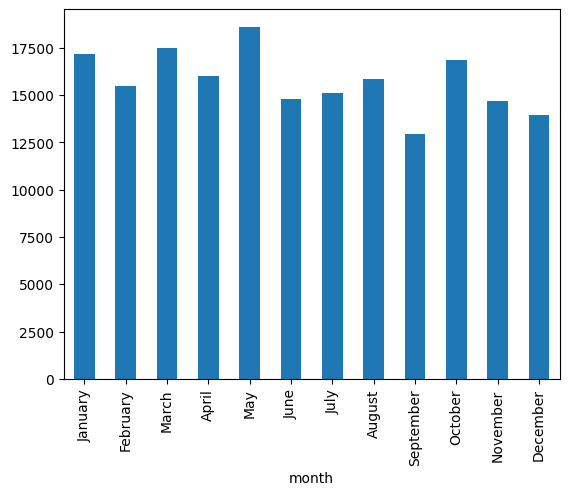

In [26]:
#Display the corrected dataframe
month_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
new_df['month'] = pd.Categorical(new_df['month'], categories=month_order, ordered=True)

new_df['month'].value_counts().sort_index().plot(kind='bar')
plt.show()

<Axes: xlabel='year_vote'>

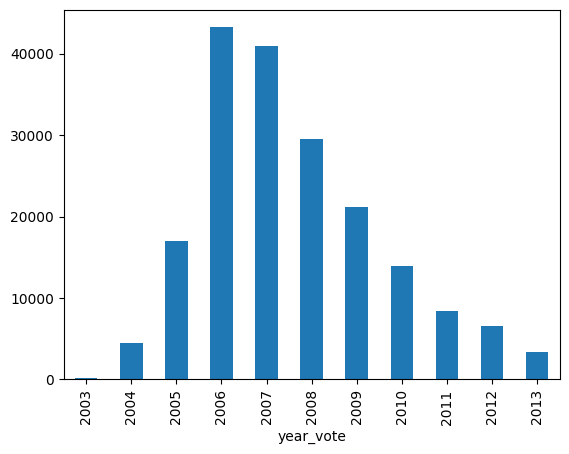

In [27]:
#Look at the distribution of the number of votes per years
new_df['year_vote'].value_counts().sort_index().plot(kind='bar')

The values for the years seems also to be ok. 

In [28]:
new_df['date_vote'] = pd.to_datetime(new_df['day'].astype(str) + ' ' +
                            new_df['month'].astype(str) + ' ' +
                            new_df['year_vote'].astype(str) + ' ' +
                            new_df['hour'].astype(str) + ':' +
                            new_df['minute'].astype(str),
                            format='%d %B %Y %H:%M' , errors = 'coerce')

new_df.drop(['hour', 'minute', 'day', 'month', 'year_vote'], axis=1, inplace=True)
new_df

,source,target,vote,result,year_election,date_vote,comment
0,Steel1943,BDD,1,1,2013,2013-04-19 23:13:00,'''Support''' as co-nom.
1,Cuchullain,BDD,1,1,2013,2013-04-20 01:04:00,'''Support''' as nominator.--
2,INeverCry,BDD,1,1,2013,2013-04-19 23:43:00,'''Support''' per noms.
3,Cncmaster,BDD,1,1,2013,2013-04-20 00:11:00,'''Support''' per noms. BDD is a strong contri...
4,Miniapolis,BDD,1,1,2013,2013-04-20 00:56:00,"'''Support''', with great pleasure. I work wit..."
...,...,...,...,...,...,...,...
198270,172,Vancouverguy,1,1,2003,2003-09-02 02:51:00,Support
198271,Angela,WhisperToMe,1,1,2003,2003-11-26 23:45:00,Support.
198272,Jiang,WhisperToMe,1,1,2003,NaT,Support. --
198273,Pakaran,WhisperToMe,1,1,2003,2003-12-05 05:38:00,Support. Age has nothing to do with maturity....


In [29]:
#Look at the number of missing dates of votes
non_date_votes = new_df['date_vote'].isnull().sum()
total_count = new_df['target'].count()
print(f'The number of votes for which the date is missing or incorrect is {non_date_votes}')
print(f'This represents {(non_date_votes/total_count)*100:.2f}% of the data.')

The number of votes for which the date is missing or incorrect is 9368
This represents 4.72% of the data.


### 2.2 Dive into user name source

In [30]:
#Transform the source column to string
new_df['source'] = new_df['source'].astype(str)

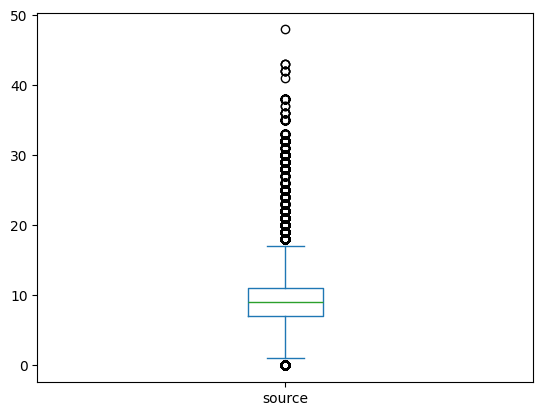

In [37]:
#Look at the distribution of the length of the source tags with a box plot
new_df['source'].str.len().plot(kind='box')
plt.show()

In [45]:
#We look at the outliers manually to check any discountinuites
new_df[new_df['source'].str.len() > 40]

,source,target,vote,result,year_election,date_vote,comment
75726,ManymerrymenmakingmuchmoneyinthemonthofMay,Golich17,-1,-1,2008,2008-06-22 20:18:00,'''Oppose.''' Greater variety of experience is...
76212,ManymerrymenmakingmuchmoneyinthemonthofMay,Headbomb,-1,-1,2008,2008-06-22 20:16:00,'''Weak oppose.''' User needs to grow and learn.
76425,Account created to post on Reference Desk,Iamawesome800,-1,-1,2008,2008-12-13 03:36:00,"'''Oppose''' Consider helping around at ""admin..."
135882,Vice President In Charge Of Office Supplies,Guinnog,1,1,2006,2006-08-30 00:04:00,'''Support''' I too enjoy beer. Whatever this ...
146871,Vice President In Charge Of Office Supplies,Runcorn,1,1,2006,2006-08-25 12:19:00,'''Support''' Looks good. I also do the little...
161105,Myrtone (the strict Australian wikipedian),Jesus on Wheels,1,-1,2006,2006-05-22 14:31:00,'''Strong Support''' Jesus On Wheels needs mor...
162487,GreatScott! Great Flamin' Cheeseballs From Above,Llama man,1,-1,2006,2006-12-01 23:39:00,'''weak support.''' I don't know him very wel...
164767,Vice President In Charge Of Office Supplies,Patchouli2,0,-1,2006,2006-08-25 12:23:00,"Per Siva, too soon to tell."
167740,The Coffee Shop That Smiles Upon The River,Siva1979,1,-1,2006,2006-08-20 16:01:00,'''Support''': Per Forest H2.


In [46]:
#We look at the outliers manually to check any discountinuites
new_df[new_df['source'].str.len() < 1]

,source,target,vote,result,year_election,date_vote,comment
707,,Jason Quinn,0,1,2013,NaT,
708,,Jason Quinn,0,1,2013,NaT,
793,,Legoktm,1,1,2013,NaT,
1126,,Mattythewhite,-1,1,2013,NaT,
1128,,Mattythewhite,-1,1,2013,NaT,
...,...,...,...,...,...,...,...
198052,,Yelyos,1,-1,2004,NaT,
198116,,Christopher Mahan,1,1,2003,NaT,
198171,,Jwrosenzweig,1,1,2003,NaT,
198217,,Patrick,1,1,2003,NaT,


While examining the outliers in relation to their source tags:
- It's observed that outliers possessing source tags longer than 25 characters typically do not present specific issues.
- A significant portion of these outliers are identified to have empty source tag lengths. Consequently, we've opted to exclude votes linked with empty source tags. This decision aligns with our objective to utilize the data for community building and to track user interactions. Allowing votes from empty source tags might skew our community analysis, potentially leading to an imbalance where certain users' votes are disproportionately influential compared to others.

In [48]:
#Look at the number of unique source users
unique_voters = new_df['source'].nunique()
print(f'The number of unique voters is {unique_voters}')

#Look at the number of null values for the source
nan_source = new_df[new_df.source == '']['source'].count()
print(f'The number of voters without tags is {nan_source}')

The number of unique voters is 10417
The number of voters without tags is 1661


In [49]:
#Remove the rows with votes associated to empty source 
new_df = new_df[new_df.source != '']

<Axes: ylabel='Frequency'>

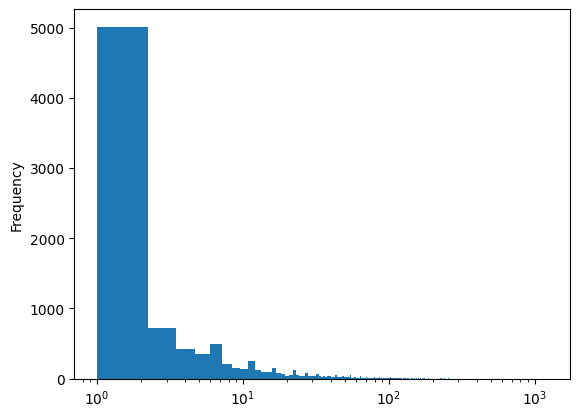

In [50]:
new_df.groupby('source').source.count().plot(kind='hist', bins=1000, logx=True)

In [51]:
perc_uniq = (new_df.groupby('source').source.count() == 1).sum() / new_df.groupby('source').source.count().count()

print(f"{perc_uniq * 100:.2f}% of the voters have only voted once.")

36.42% of the voters have only voted once.


### 2.3 Dive into target user name 

In [52]:
#Look at the number of unique source users
unique_electives = new_df['target'].nunique()
print(f'The number of unique users running for election is {unique_electives}')

#Look at the number of null values for the source
nan_target = new_df[new_df.target == '']['target'].count()
print(f'The number of nan values for the source is {nan_target}')

The number of unique users running for election is 3491
The number of nan values for the source is 0


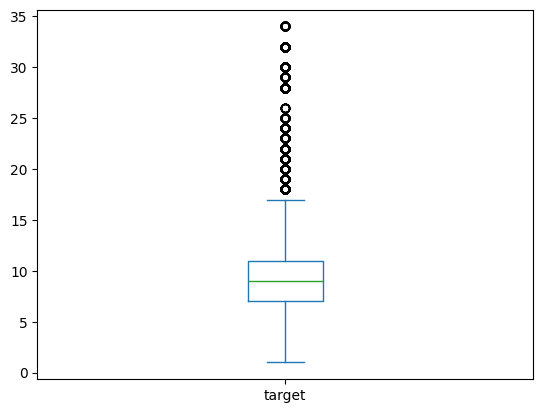

In [54]:
#Look at the distribution of the length of the source tags with a box plot
new_df['target'].str.len().plot(kind='box')
plt.show()

In [59]:
new_df[new_df.target.str.len() > 30]

,source,target,vote,result,year_election,date_vote,comment
15256,Hurricanefan25,The Blade of the Northern Lights,1,1,2011,2011-11-28 18:46:00,'''Support''' I've seen this user around a bit...
15257,Swarm,The Blade of the Northern Lights,1,1,2011,2011-11-28 18:47:00,'''Support''' without hesitation. Yes. ''
15258,Snottywong,The Blade of the Northern Lights,1,1,2011,2011-11-28 18:52:00,"'''Support''' Blade is clearly here to help, a..."
15259,Mkativerata,The Blade of the Northern Lights,1,1,2011,2011-11-28 18:54:00,"The candidate is excellent, capable, clearly h..."
15260,Bobrayner,The Blade of the Northern Lights,1,1,2011,2011-11-28 19:07:00,"'''Support'''. Competent, hardworking, and can..."
...,...,...,...,...,...,...,...
155744,Splash,"Can't sleep, clown will eat me too",-1,-1,2006,2006-03-26 18:21:00,'''Oppose''' anyone who present the community ...
155745,Talrias,"Can't sleep, clown will eat me too",-1,-1,2006,2006-03-26 18:39:00,I agree with Splash. By preventing a proper di...
155746,W.marsh,"Can't sleep, clown will eat me too",-1,-1,2006,2006-03-26 18:49:00,It sets a dangerous precedent if a nomination ...
155747,Johnleemk,"Can't sleep, clown will eat me too",0,-1,2006,2006-03-26 18:43:00,"Would have supported, but I agree -- this is a..."


### 2.4 Dive into the year_election values

count     196614
unique        11
top         2006
freq       44525
Name: year_election, dtype: object


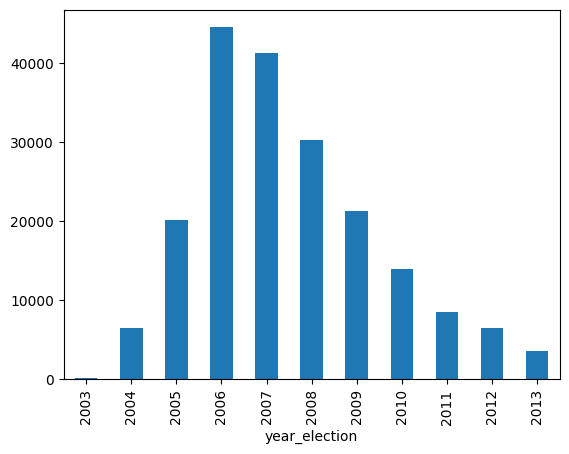

In [60]:
#Look at the distribution of the values for year_election
print(new_df['year_election'].describe())
new_df['year_election'].value_counts().sort_index().plot(kind='bar')
plt.show()

### 2.5 Dive into the vote and results values


count     196614
unique         3
top            1
freq      143879
Name: vote, dtype: object


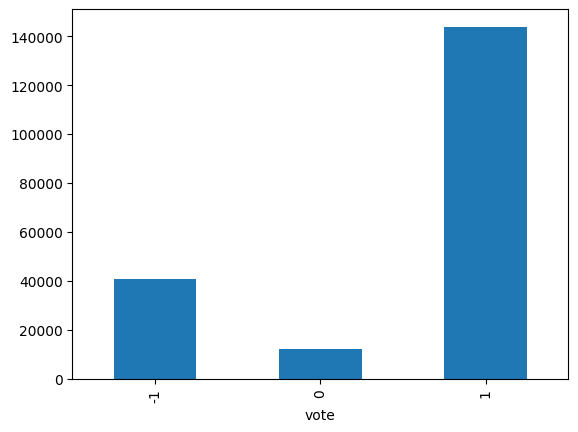

In [61]:
#Look at the distribution of the values for the vote
print(new_df['vote'].describe())
new_df['vote'].value_counts().sort_index().plot(kind='bar')
plt.show()

In [62]:
value_perc_vote = new_df['vote'].value_counts(normalize=True) * 100

# Print the percentages
print("Percentage of Each Unique Value in vote:")
print(value_perc_vote)

Percentage of Each Unique Value in vote:
vote
1     73.178410
-1    20.683675
0      6.137915
Name: proportion, dtype: float64


count     196614
unique         2
top            1
freq      122524
Name: result, dtype: object


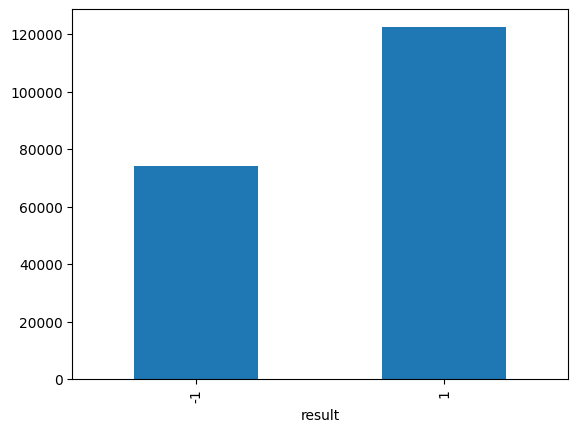

In [63]:
#Look at the distribution of the values for the result
print(new_df['result'].describe())
new_df['result'].value_counts().sort_index().plot(kind='bar')
plt.show()

In [64]:
value_perc_result = new_df['result'].value_counts(normalize=True) * 100

# Print the percentages
print("Percentage of Each Unique Value in result:")
print(value_perc_result)

Percentage of Each Unique Value in result:
result
1     62.317027
-1    37.682973
Name: proportion, dtype: float64


## 3. Voting results analysis

In [65]:
cleaned_df = new_df.copy(deep=True)

cleaned_df['vote'] = cleaned_df['vote'].astype(int)
cleaned_df['result'] = cleaned_df['result'].astype(int)
cleaned_df['year_election'] = cleaned_df['year_election'].astype(int)

In [28]:
cleaned_df['year_election'].unique()

array([2013, 2012, 2011, 2010, 2009, 2008, 2007, 2006, 2005, 2004, 2003])

In [66]:
cleaned_df

,source,target,vote,result,year_election,date_vote,comment
0,Steel1943,BDD,1,1,2013,2013-04-19 23:13:00,'''Support''' as co-nom.
1,Cuchullain,BDD,1,1,2013,2013-04-20 01:04:00,'''Support''' as nominator.--
2,INeverCry,BDD,1,1,2013,2013-04-19 23:43:00,'''Support''' per noms.
3,Cncmaster,BDD,1,1,2013,2013-04-20 00:11:00,'''Support''' per noms. BDD is a strong contri...
4,Miniapolis,BDD,1,1,2013,2013-04-20 00:56:00,"'''Support''', with great pleasure. I work wit..."
...,...,...,...,...,...,...,...
198270,172,Vancouverguy,1,1,2003,2003-09-02 02:51:00,Support
198271,Angela,WhisperToMe,1,1,2003,2003-11-26 23:45:00,Support.
198272,Jiang,WhisperToMe,1,1,2003,NaT,Support. --
198273,Pakaran,WhisperToMe,1,1,2003,2003-12-05 05:38:00,Support. Age has nothing to do with maturity....


The best we can do to determine single elections is to group by target, 

In [117]:
#We compute here different statistics
multiple_elections = cleaned_df.groupby(['target' , 'result', 'year_election']).apply(lambda x : pd.Series({
    'number_of_votes' : len(x['source']), 
    'ratio_positive_votes' : x[x.vote == 1]['vote'].sum() / len(x.source), 
    'average_comment_length' : x['comment'].str.len().mean(),
})).reset_index()

In [123]:
#Look wether we have multiple rows where the target and result are the same
multiple_elections[multiple_elections.duplicated(subset=['target', 'result'], keep=False)]


,target,result,year_election,number_of_votes,ratio_positive_votes,average_comment_length
18,9cds,-1,2005,12.0,0.083333,125.083333
19,9cds,-1,2006,34.0,0.382353,189.764706
22,A Link to the Past,-1,2005,30.0,0.200000,188.066667
23,A Link to the Past,-1,2006,75.0,0.440000,162.520000
35,ACBest,-1,2007,17.0,0.117647,289.529412
...,...,...,...,...,...,...
3795,ZooPro,-1,2009,17.0,0.117647,244.529412
3796,ZooPro,-1,2010,14.0,0.071429,381.214286
3797,ZooPro,-1,2011,24.0,0.083333,378.791667
3808,^demon,1,2007,83.0,0.987952,91.963855


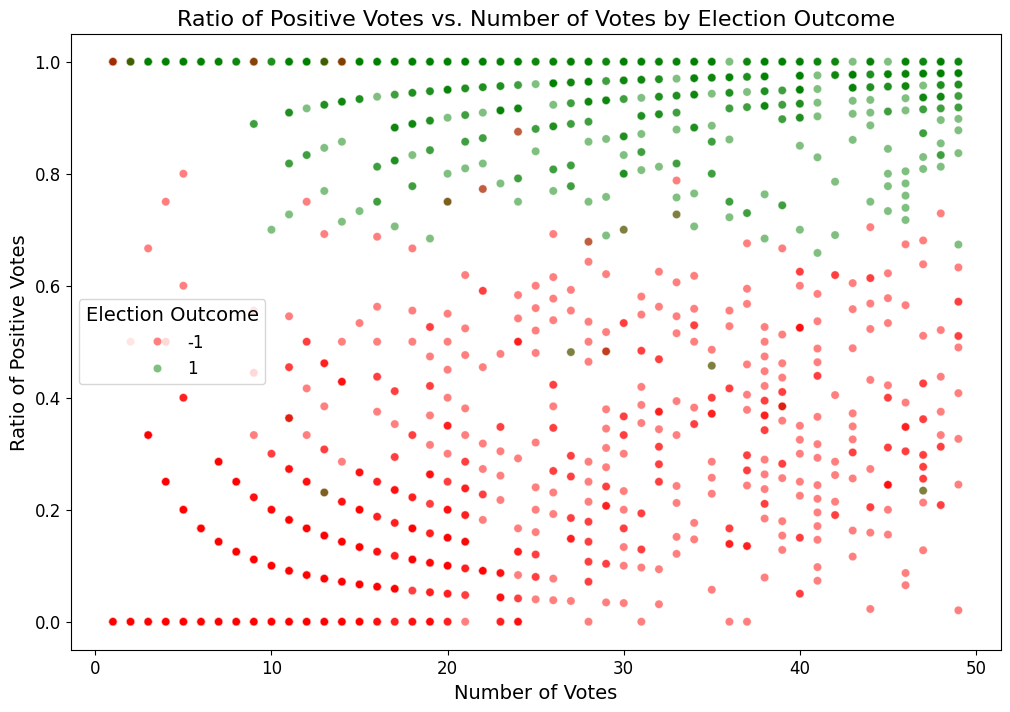

In [101]:
#Plot the ratio of positive votes for each election, an election is identified by the year of the result and the target
# Set the figure size
plt.figure(figsize=(12, 8))  # Adjust the size as needed

# Create the scatter plot
sns.scatterplot(x='number_of_votes', 
                y='ratio_positive_votes', 
                hue='result', 
                data=multiple_elections[multiple_elections['number_of_votes'] < 50],
                palette=['red', 'green'],  # Optional: Specify custom colors
                alpha=0.5)  # Optional: Adjust transparency

# Enhance plot aesthetics
plt.title('Ratio of Positive Votes vs. Number of Votes by Election Outcome', fontsize=16)
plt.xlabel('Number of Votes', fontsize=14)
plt.ylabel('Ratio of Positive Votes', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(title='Election Outcome', fontsize=12, title_fontsize=14)

plt.show()


Seems like there is a specific threshold for the percentage of positive votes for an election to be successfull. 

In [111]:
#Compute the correlation between the ratio of positive votes and the outcome of the election
stats.pearsonr(multiple_elections['ratio_positive_votes'], multiple_elections['result'])

PearsonRResult(statistic=0.8809922293325008, pvalue=0.0)

Very high correlation between the ration of positive votes and the result of the election

<Axes: xlabel='result', ylabel='ratio_positive_votes'>

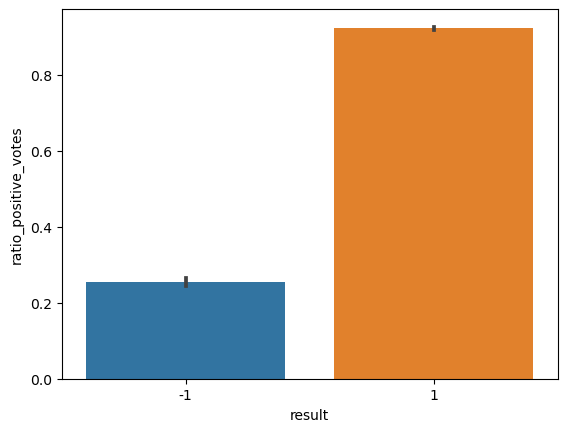

In [31]:
sns.barplot( x= 'result' , y = 'ratio_positive_votes' , data = multiple_elections)

/Users/robinjaccard/opt/anaconda3/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


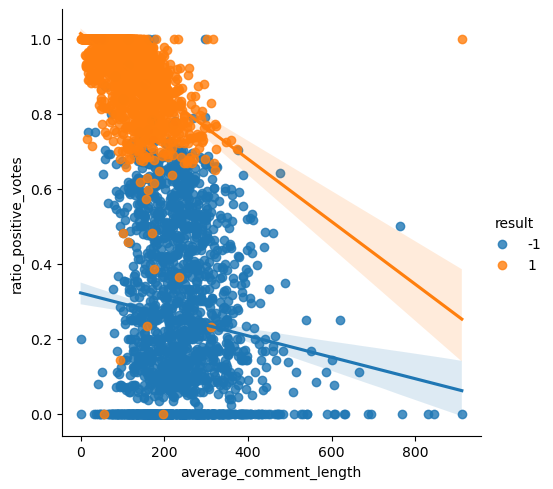

In [32]:
sns.lmplot(x = 'average_comment_length' , y = 'ratio_positive_votes' , data = multiple_elections , hue = 'result')

In [33]:
#Compute the correlation between the outcome of the vote and the ratio of positive votes
multiple_elections['result'].corr(multiple_elections['ratio_positive_votes'])

#Compute the correlation between the outcome of the vote and the average length of the comment
multiple_elections['result'].corr(multiple_elections['average_comment_length'])


-0.615878234971494

## 4. Number of votes analysis

In [34]:
multiple_elections['election_year'].unique().sort()

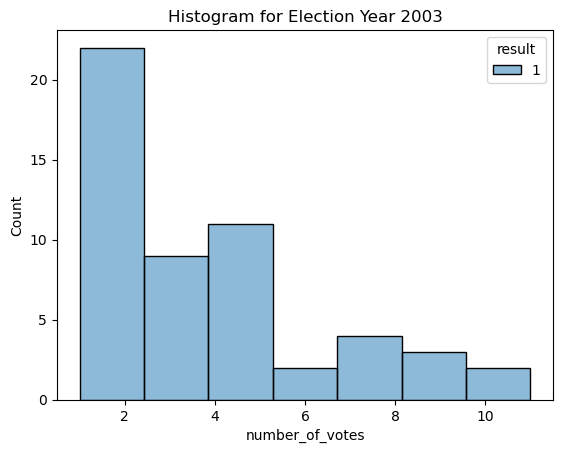

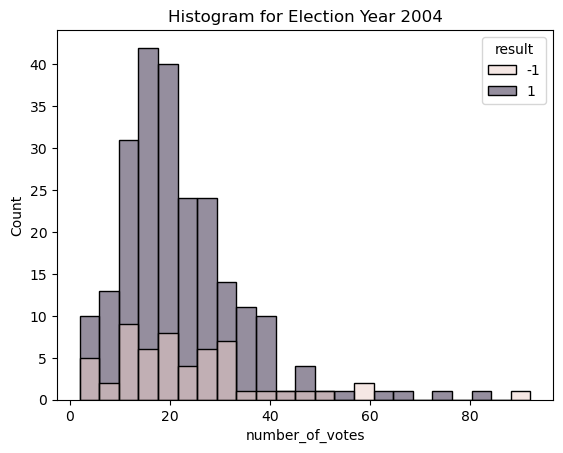

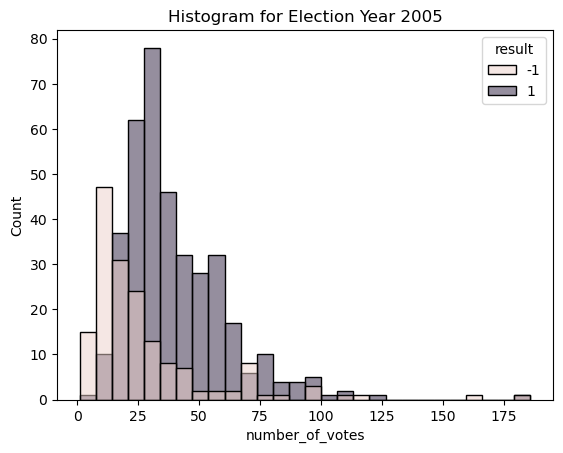

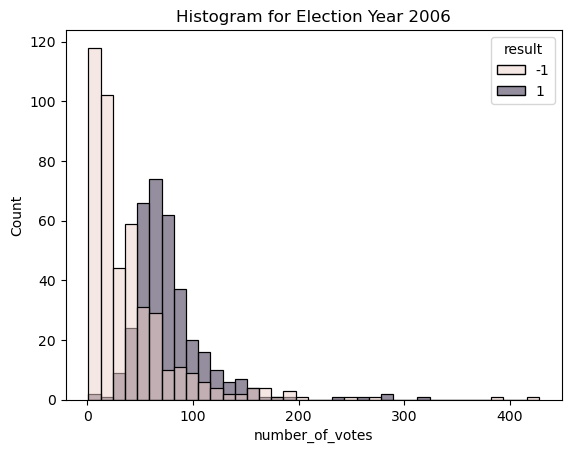

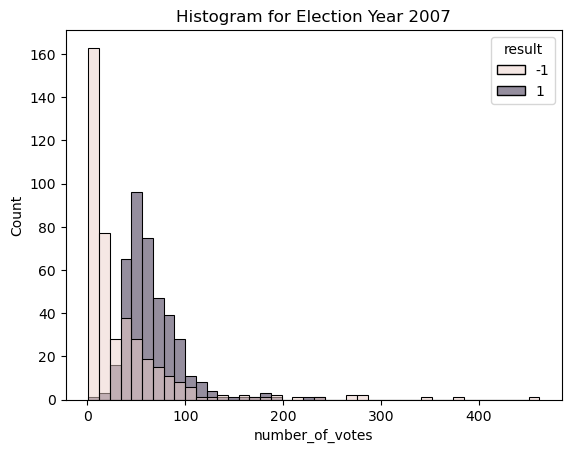

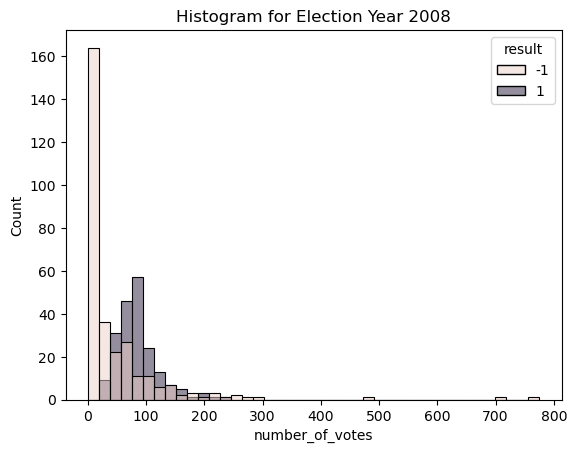

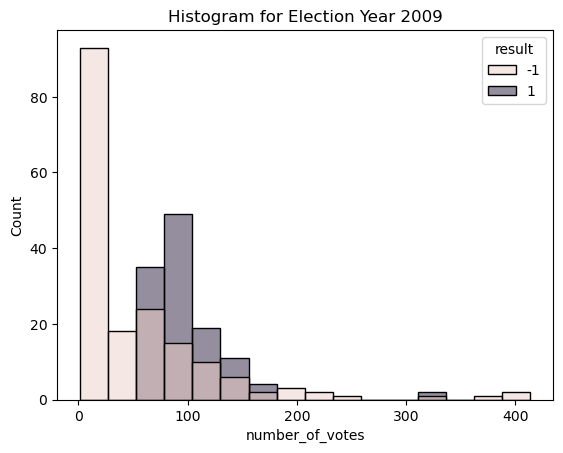

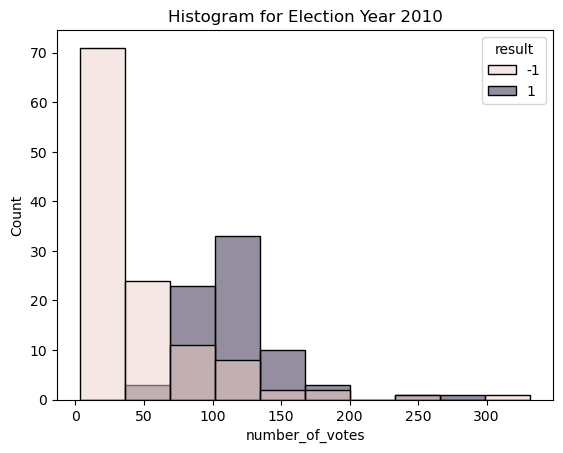

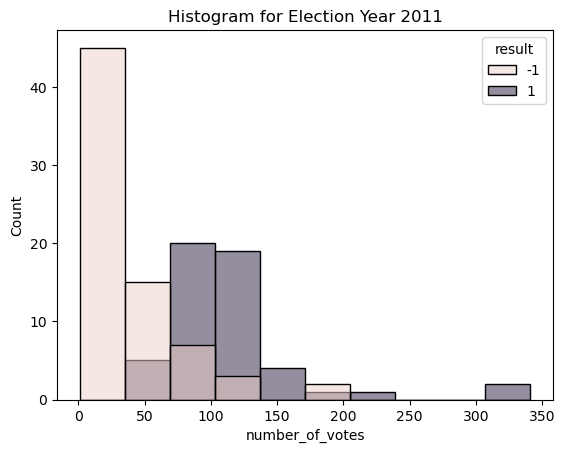

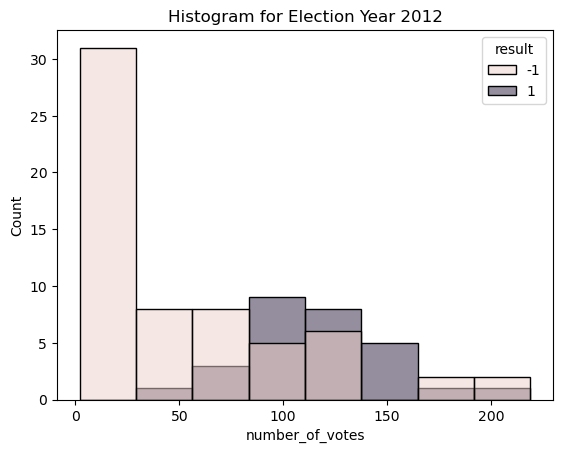

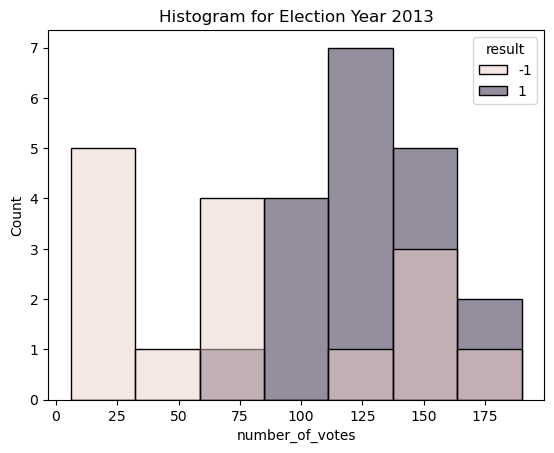

In [35]:
# Assuming 'election_year' is of type int
for year in sorted(multiple_elections['election_year'].unique()):
    data_subset = multiple_elections[multiple_elections['election_year'] == year]
    
    sns.histplot(x='number_of_votes', data=data_subset, hue='result', log_scale=(False, False))
    plt.title(f'Histogram for Election Year {int(year)}')
    plt.show()

<Axes: xlabel='number_of_votes', ylabel='Count'>

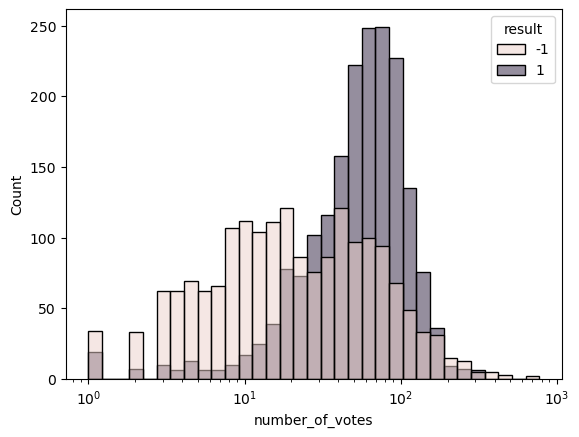

In [36]:
sns.histplot(x = 'number_of_votes', data = multiple_elections , hue = 'result', log_scale= (True, False))

In [37]:
new_df.groupby(["target", "result"])["source"].count().median()

41.0

In [38]:
new_df.groupby(["target", "result"])["source"].count().mean()

52.75395760665415